<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_8/Assignment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 08

This notebook is once again not very clean, feel free to skip over all parts that are not marked as interesting.

In [41]:
import numpy as np
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm
import shutil
import random
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#### Util Functions

These can safely be skipped, they are mostly copied from the class session code.

In [42]:
# utils
# colors from: https://epub.wu.ac.at/1692/1/document.pdf
COLORS = [[2,63,165],[125,135,185],[190,193,212],[214,188,192],[187,119,132],
               [142,6,59],[74,111,227],[133,149,225],[181,187,227],[230,175,185],
               [224,123,145],[211,63,106],[17,198,56],[141,213,147],[198,222,199],
               [234,211,198],[240,185,141],[239,151,8],[15,207,192],[156,222,214],
               [213,234,231],[243,225,235],[246,196,225],[247,156,212]]
COLORS = [np.array(color)/255. for color in COLORS]

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("checkpoints")):
        os.makedirs("checkpoints")
    savepath = f"checkpoints/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(train_loss, val_loss, start=0):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_train = smooth(train_loss, 31)
    ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")
    
    ax[1].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    smooth_val = smooth(val_loss, 31)
    N_ITERS = len(val_loss)
    ax[2].plot(np.arange(start, N_ITERS)+start, val_loss[start:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[2].plot(np.arange(start, N_ITERS)+start, smooth_val[start:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_yscale("log")
    ax[2].set_title(f"Valid Progress")

    return

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], color=COLORS[l])
    ax.legend(loc="best")

def display_projections_images(points, labels, dataset, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
   
    _, ax = plt.subplots(1,1,figsize=(36,24))
    
    for l in np.unique(labels):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], color=COLORS[l]) 

    for i, point in enumerate(points):
        xy = [point[0], point[1]]
        arr_img = plt.imread(dataset.filenames[i], format='jpg')
        l = labels[i]
        imagebox = OffsetImage(arr_img, zoom=.08)
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            pad=0.1,
                            bboxprops=dict(edgecolor=COLORS[l], lw=2)
                            )

        ax.add_artist(ab)
    ax.legend(loc="best")
    plt.show()

#### Preparing the Dataset in Colab

We have a zip file containing *LFW* and the corresponding training and testing splits in our google drive. This is mounted here and then unpacked to Colabs local file structure.  

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
if not os.path.exists('data'):
    os.makedirs('data')
try:
  shutil.rmtree('data/lfw')
except:
  pass

In [45]:
print('Extracting files...')
!unzip /content/gdrive/MyDrive/lfw.zip -d data &> /dev/null
print('Done')

Extracting files...
Done


#### Dataset

This cell is maybe a tiny bit interesting. We proceed almost like in the class session, but put a list containing the paths to all dataset elements at the core of this dataset. Since we have text files with names of people in the training and testing set, we can use these not only to get the file paths, but also the labels of each image. 

One detail of this dataset is the parameter **N**, which is the number of images a person must at least be featured in to be included in the dataset. **N** should be $2$ at minimum, so that we can also select a positive example which differs from the anchor image. In this notebook, we discard many classes by using $N = 16$, because the resulting visualizations are much less cluttered and allow cleaner visualizations of the representations which the model forms. We think this is fair as the training and testing data is reduced according to the same constraint.

In [46]:
from torch.utils.data import Dataset

class TripletDataset(Dataset):
    """
    Dataset class which draws from the LFW file structure based on text files describing training and validation splits.
    The available modes are 'Train' and 'Test', referencing the suggested training and testing splits for LFW.
    For a triplet dataset, anchor images and positive examples should be different images, so only images featuring people featured in at least N >= 2 images are considered.
    By default, all images are transformed using transform, and anchor, positive and negative are additionally transformed beforehand using transform_anchor, etc.
    """
    def __init__(self, root, N=2, mode='Train', transform=None, transform_anchor=None, transform_positive=None, transform_negative=None):
        """ Dataset initializer"""
        self.root = root
        self.N = N
        assert self.N >= 2, 'A person must be featured in at least 2 images, please adjust N'
        # File which describes which images are in training/testing sets
        self.split_file = root + 'peopleDev' + mode + '.txt'
        # Read the names of all subjects along with the number of photos that each is featured in
        tmp = np.genfromtxt(self.split_file, skip_header=1, dtype=np.str)
        # Store this info in separate numpy arrays
        labels, num_images= [], []
        for label, num_img in tmp:
          labels.append(label)
          num_images.append(int(num_img))
        num_images = np.array(num_images)
        labels = np.array(labels)
        mask = num_images >= self.N
        # Obtain the names of the subjects that are kept
        masked_labels = labels[mask]
        self.classes = masked_labels
        # Assign each name an integer label
        label_inds = np.arange(len(masked_labels))
        # Obtain the number of images that each subject kept is featured in
        masked_num_images = num_images[mask]
        # For each remaining image in the data obtain the corresponding label
        self.item_labels = np.repeat(label_inds, masked_num_images)
        # For each remaining image cache at which index it is in its respective folder
        local_item_inds = [np.arange(n_imgs)+1 for n_imgs in masked_num_images]
        local_item_inds = np.concatenate(local_item_inds)
        # Convert this to a list of all filenames of images in the testing data
        self.filenames = [self.root+'lfw/'+masked_labels[self.item_labels[i]]+'/'+masked_labels[self.item_labels[i]]+'_'+f'{local_item_inds[i]:04d}.jpg' for i in range(self.item_labels.shape[0])]
        self.arange= np.arange(len(self.filenames))
        self.transform = transform
        self.transform_anchor = transform_anchor
        self.transform_positive = transform_positive
        self.transform_negative = transform_negative

        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.filenames)

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # Obtain the anchor
        anchor_img_path, anchor_lbl = self.filenames[i], self.item_labels[i]
        # Set up indices and labels not containing the anchor element
        ids = np.delete(self.arange, i)
        labels = np.delete(self.item_labels, i)
        # Partition this into positive and negative examples
        pos_ids = ids[labels == anchor_lbl]
        neg_ids = ids[labels != anchor_lbl]
        # Sample random positive and negative example
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_ids).item()
        pos_img_path, pos_lbl = self.filenames[pos_id], self.item_labels[pos_id]
        neg_img_path, neg_lbl = self.filenames[neg_id], self.item_labels[neg_id]
        
        anchor_img, pos_img, neg_img = Image.open(anchor_img_path), Image.open(pos_img_path), Image.open(neg_img_path)
        if self.transform_anchor:
            anchor_img = self.transform_anchor(anchor_img)
        if self.transform_positive:
            pos_img = self.transform_positive(pos_img)
        if self.transform_negative:
            neg_img = self.transform_negative(neg_img)
        if self.transform:
            anchor_img, pos_img, neg_img = self.transform(anchor_img), self.transform(pos_img), self.transform(neg_img)

              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

#### Setup for Datasets and Dataloaders

Here we intialize the training and testings sets as well as the corresponding dataloaders. 

Note that we normalize the images in order to accomodate the pretrained resnet and also apply some image augmentation to the positive examples in an attempt to squeeze a little more out of this dataset.

In [47]:
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)
])

pos_transform = transforms.Compose([transforms.RandomResizedCrop(size=(250,250), scale=(0.8, 1.0)),
                                    transforms.RandomHorizontalFlip(p=0.5), 
                                    transforms.ColorJitter(brightness=0.1, contrast=.4, saturation=0.2, hue=0.05)
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(MEAN, STD)],
   std= [1/s for s in STD]
)

MIN_NUM_IMAGES = 16

train_dataset = TripletDataset(root='data/lfw/', mode='Train', N=MIN_NUM_IMAGES, transform=data_transforms, transform_positive=pos_transform)
train_names = train_dataset.classes

test_dataset = TripletDataset(root='data/lfw/', mode='Test', N=MIN_NUM_IMAGES, transform=data_transforms)
test_names = test_dataset.classes

print(f'The number of training samples is {len(train_dataset)}.')
print(f'The number of training classes is {len(train_names)}.')
print(f'The number of testing samples is {len(test_dataset)}.')
print(f'The number of testing classes is {len(test_names)}.')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=48, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=48, shuffle=False)

The number of training samples is 2654.
The number of training classes is 62.
The number of testing samples is 776.
The number of testing classes is 23.


#### The Model

The normalization layer is copied from class, and the model is built according to the specifications on the sheet. The hidden and embedding dimensions were selected like in the [TriNet paper](https://arxiv.org/pdf/1703.07737.pdf). It is also specified there that batch normalization is applied in the fully connected final layers of the model.

We weren't sure whether the average pooling is included or not included in the CNN, but there is a flag in the function which loads the resnet18 to control this.

In [48]:
import torchvision.models as models

class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1,2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized


class TriNet(nn.Module):
    """ 
    Implementation of a TriNet with resnet18 backbone
    """
    def __init__(self, h_dim=1024, emb_dim=128):
        """ Module initializer """
        super().__init__()
        
        # Convolutional feature extractor - Pretrained ResNet18
        self.cnn, flat_dim = self.make_encoder()
      
        #print(flat_dim)
        self.fc = nn.Sequential(*[nn.Linear(flat_dim, h_dim), nn.BatchNorm1d(h_dim), nn.Linear(h_dim, emb_dim)])
        
        # auxiliar layers
        self.norm = NormLayer()
    
        return

    def make_encoder(self, use_avg_pool=False):
        resnet18 = models.resnet18(pretrained=True)
        encoder_list = []
        encoder_list +=  [module for (_, module) in resnet18.named_children()]
        encoder_list = encoder_list[:-1]
        if use_avg_pool:
            encoder_list += [nn.Flatten()]
            out_shape = 512
        else:
            encoder_list[-1] = nn.Flatten()
            out_shape = 32768
        return nn.Sequential(*encoder_list), out_shape

    def freeze_cnn(self):
        self.cnn.requires_grad_(False)
    
    def unfreeze_cnn(self):
        self.cnn.requires_grad_(True)
        
    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x_flat = self.cnn(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self, anchor, positive, negative):
        """ Forwarding a triplet """
        #print(anchor.shape, positive.shape, negative.shape)
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        return anchor_emb, positive_emb, negative_emb

#### The Loss Function

We use the criterion exactly as defined in lab session 8.

In [49]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing
        if(self.reduce == "mean"):
            loss = torch.mean(loss)
        else:
            loss = torch.sum(loss)
            
        return loss

#### The Trainer class

This is also taken from lab session 8.

In [50]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
    
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, ((anchors, positives, negatives),_) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
    
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives), _ in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

#### Training

In this notebook, we only complete the task of loading a pretrained resnet18 backbone and fine-tuning it. This is because we were a bit pressed on time but also quite sure that fully training it would be unneccesary and probably worse. Even the Trinet paper does not attempt this, and instead suggests a different model for training from scratch.

Since this worked well for assignment 6, we first freeze the pretrained CNN and train just the fully connected layers for some warmup epochs. Then we train both together to fine-tune the result.

First we initialize the model and criterion

In [51]:
model = TriNet()
model.freeze_cnn()
criterion = TripletLoss(margin=0.2)

Now the warmup training occurs, the number of epochs was selected such that this takes around 10 minutes.

In [52]:
trainer_warmup = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=test_loader, n_iters=501)
trainer_warmup.fit()

Valid loss @ iteration 0: Loss=0.17896927400108645
Valid loss @ iteration 250: Loss=0.14047463051974773
Valid loss @ iteration 500: Loss=0.12860323707847035


Finally the full model is trained for more epochs.

In [53]:
model = trainer_warmup.model
model.unfreeze_cnn()
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=test_loader, n_iters=1501)
trainer.fit()

Valid loss @ iteration 0: Loss=0.16481492405428605
Valid loss @ iteration 250: Loss=0.08667177706956863
Valid loss @ iteration 500: Loss=0.08047272527919096
Valid loss @ iteration 750: Loss=0.08175518343683935
Valid loss @ iteration 1000: Loss=0.05115694497876307
Valid loss @ iteration 1250: Loss=0.07485382445156574
Valid loss @ iteration 1500: Loss=0.07632496451739879


In [54]:
stats = {
    "train_loss": trainer.train_loss,
    "valid_loss": trainer.valid_loss
}
save_model(trainer.model, trainer.optimizer, trainer.iter_, stats)

We use the helper function from the lab session to show the learning curves.

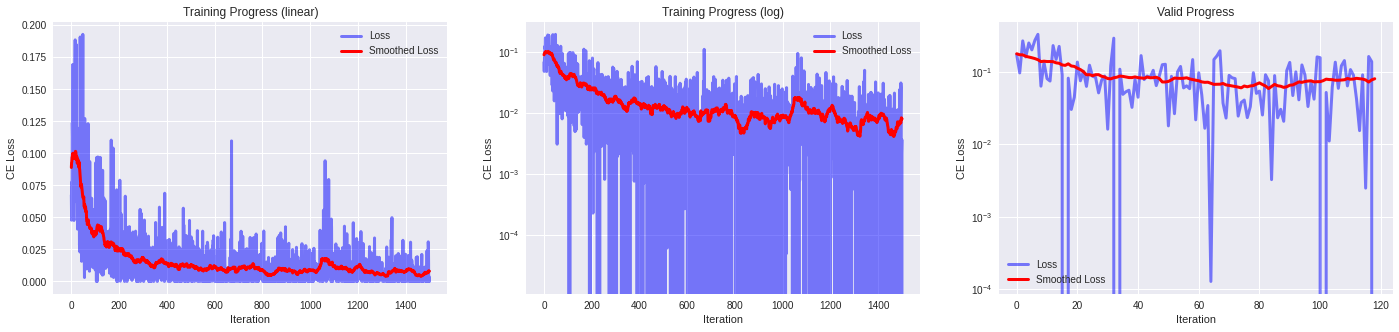

In [55]:
model, optimizer, epoch, stats = load_model(trainer.model, trainer.optimizer, savepath="checkpoints/checkpoint_epoch_1501.pth")
visualize_progress(stats["train_loss"], stats["valid_loss"], start=0)

### Visualizing the Embeddings

Since our embedding dimension is 128, we use PCA and TSNE just as presented in the lab session to produce two-dimensional versions which we can visualize.

In [56]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Obtain the trained model.

In [57]:
model = model
device = trainer.device
model = model.eval()

Apply it to each anchor image in the test set, also saving the labels and flattened images in the process.

In [58]:
imgs_flat = []
embs = []
labels = []
with torch.no_grad():
    for (anchor, _, _), (lbl,_, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)
        labels.append(lbl)
        embs.append(anchor_emb.cpu())
        imgs_flat.append(anchor.cpu().flatten(1))

labels = np.concatenate(labels)
embs = np.concatenate(embs)
imgs_flat = np.concatenate(imgs_flat)

Now apply PCA and visualize the results

In [59]:
pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)
pca_embs = PCA(n_components=2).fit_transform(embs)

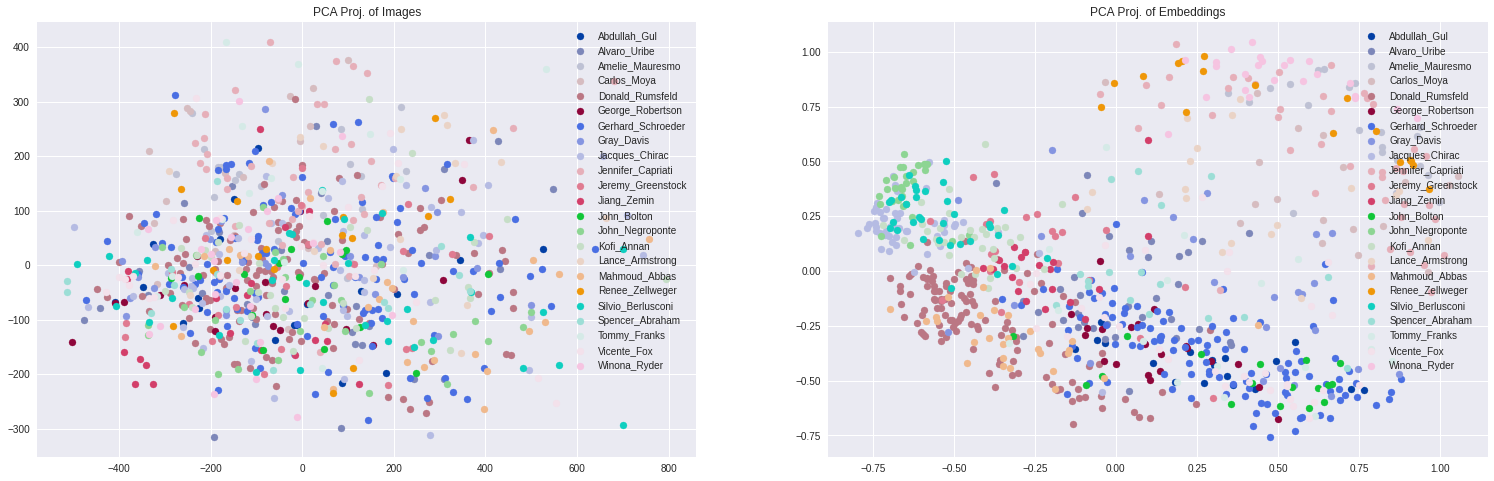

In [60]:
N = labels.shape[0]
plt.style.use('seaborn')
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(pca_embs[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("PCA Proj. of Embeddings")
plt.show()

The embeddings of the anchor images are much more organized than the images themselves, which show no clear structure when projected using PCA. Still, the result is very cluttered, so we apply TSNE next.

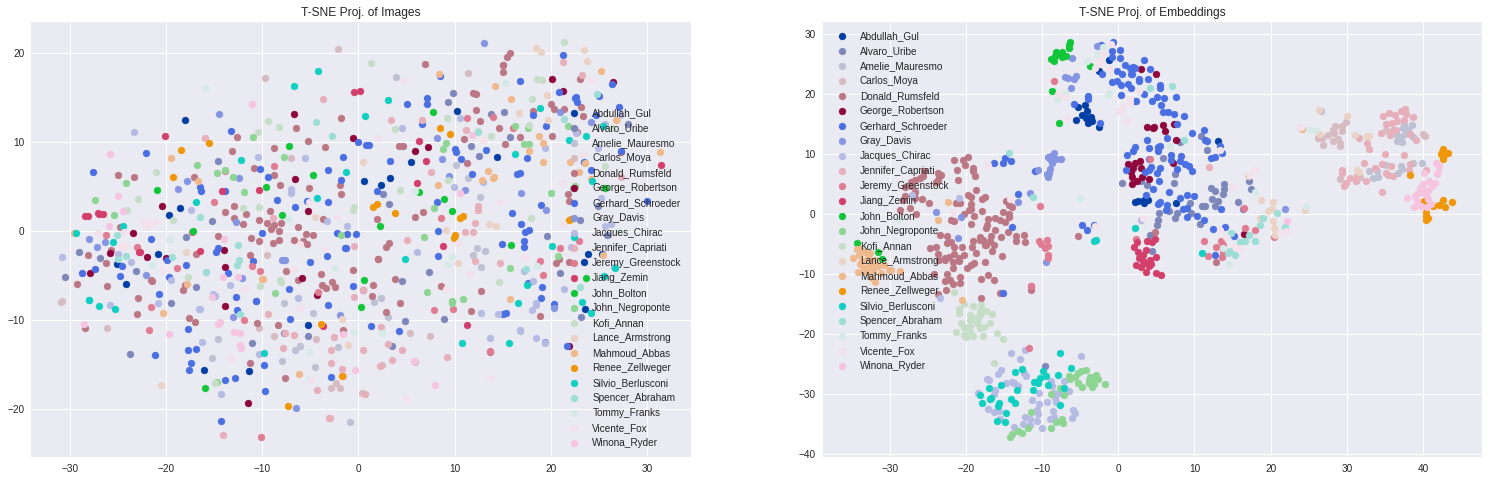

In [61]:
N = labels.shape[0]
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_embs[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Embeddings")
plt.show()

Here we can already see that some subjects in the testing set are cleary separated in the embedding space, the model seems to have learned useful representations. We reproduce both plots, inspired by the visualization in the Trinet paper, using the underlying images in place of the scattered datapoints. The color of the border around each image denotes its class.

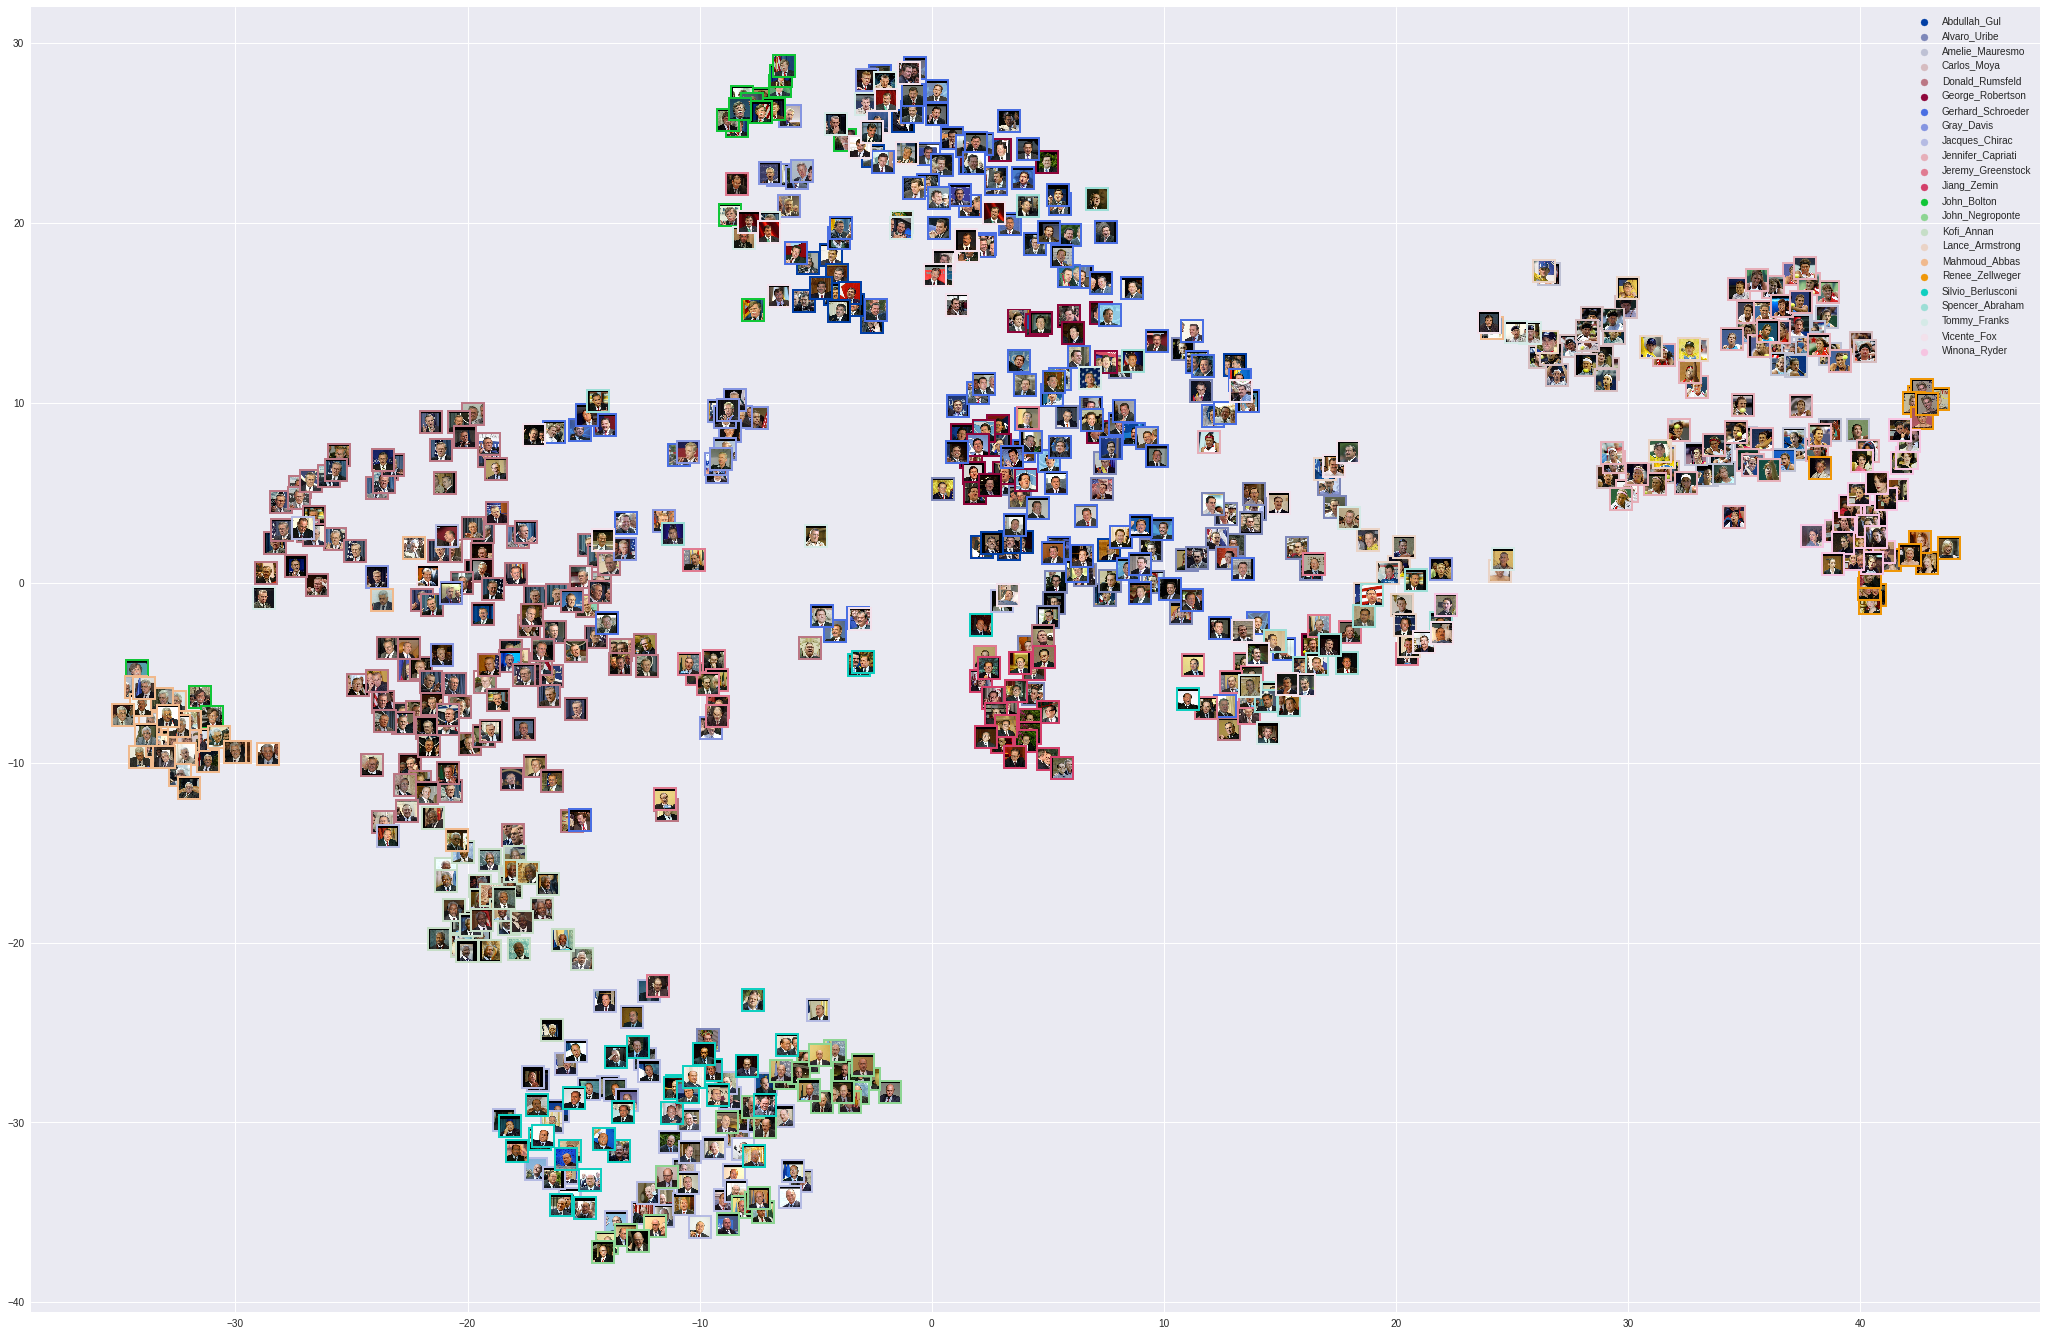

In [62]:
display_projections_images(tsne_embs, labels, test_dataset, legend=test_dataset.classes)

The datapoints are of course still at the same locations as in the first set of scatterplots, but now we can additionally see that the subjects which have not been separated well (at least in the TSNE projection of the embeddings) share some features. From our point of view the the positions of the projected image embeddings seem plausible.

It should be noted that this dataset suffers a bit from class imbalance. For example, it contains over 500 images of George W. Bush in the training set, but only a handful for most other people. This might have caused some issues here.

#### Regarding the Compression Quality

To obtain ARI scores as presented in the lab session, we replace KMeans by MiniBatchKMeans in this application. This is due to the large dimensionality of the flattened images, which would take very long to cluster using the traditional method.

In [63]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

In [64]:
kmeans_imgs = MiniBatchKMeans(n_clusters=len(test_dataset.classes), random_state=0).fit(imgs_flat)
kmeans_embs = MiniBatchKMeans(n_clusters=len(test_dataset.classes), random_state=0).fit(embs)

In [65]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_embs = adjusted_rand_score(labels, kmeans_embs.labels_)

In [66]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering embeddings achieves ARI={round(ari_embs*100,2)}%")

Clustering images achieves  ARI=2.47%
Clustering embeddings achieves ARI=31.22%


In [67]:
print(f"Compression ratio: {embs.shape[-1]}/{imgs_flat.shape[-1]}  = {round(embs.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 128/187500  = 0.07%


The compression ratio is of course quite nice, and the ARI score is increased significantly for the learned embeddings. Since 'classification' is a difficult problem for this dataset due to many small classes, the results are however not as strong as for the FMNIST dataset example shown in the lab session.